In [2]:
import numpy as np
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2 as ps
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

In [3]:
conn = ps.connect(dbname="capstone",
                  user="postgres",
                  password="12345",
                  port = "5432")

Zaman İçinde Satış Trendlerinin Analizi

In [4]:
sql = """SELECT 
    EXTRACT(YEAR FROM orders.order_date) AS SalesYear,
    EXTRACT(MONTH FROM orders.order_date) AS SalesMonth,
    ROUND(SUM(order_details.quantity * order_details.unit_price)::numeric, 2) AS TotalSales
FROM orders
JOIN order_details ON orders.order_id = order_details.order_id
GROUP BY SalesYear, SalesMonth
ORDER BY SalesYear, SalesMonth;
"""

In [5]:
df = sqlio.read_sql_query(sql,conn)
df.head()

,salesyear,salesmonth,totalsales
0,1996.0,7.0,30192.1
1,1996.0,8.0,26609.4
2,1996.0,9.0,27636.0
3,1996.0,10.0,41203.6
4,1996.0,11.0,49704.0


In [6]:
df.shape

(23, 3)

In [7]:
# Combine the Year and Month columns to create a "datetime" column
df['Date'] = pd.to_datetime(df['salesyear'].astype(int).astype(str) + '-' + df['salesmonth'].astype(int).astype(str) + '-01')

# Remove unnecessary columns for visualization
df = df[['Date', 'totalsales']]

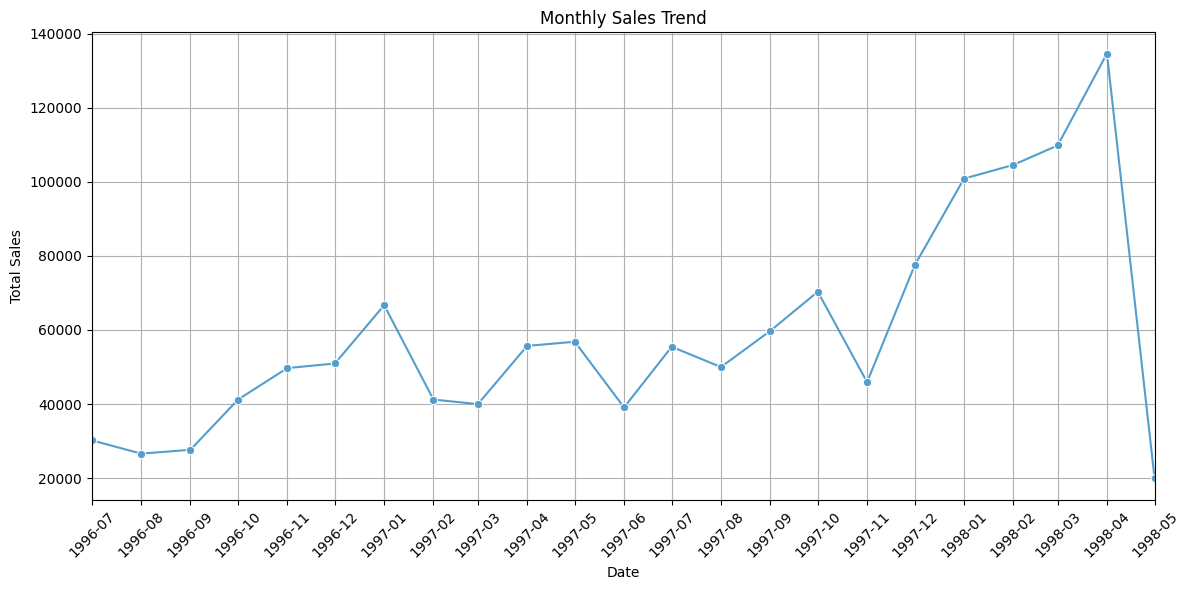

In [8]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Date', y='totalsales', marker="o", color=sns.color_palette('Blues')[3])
plt.title("Monthly Sales Trend")
plt.xlabel("Date")
plt.ylabel("Total Sales")

# Set the x-axis to display dates monthly and format as Year-Month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

# Limit x-axis to actual data range to avoid extra dates
plt.xlim(df['Date'].min(), df['Date'].max())

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Ürün Fiyatlarının Dağılımı

In [9]:
# Fetch product prices
sql = """SELECT product_name, unit_price 
FROM products;"""
df = pd.read_sql(sql, conn)

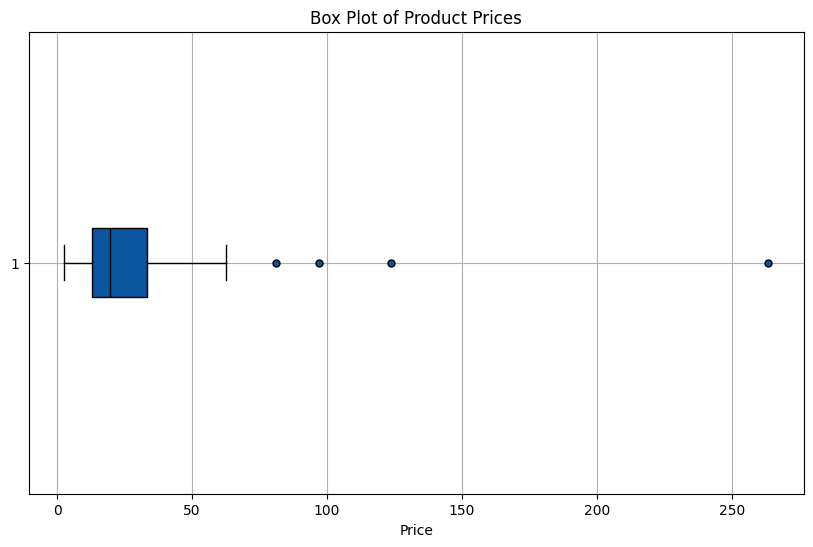

In [ ]:
color = sns.color_palette('Blues')[5]

# Box Plot with filled box and color customization
plt.figure(figsize=(10, 6))
plt.boxplot(df['unit_price'], vert=False, 
            patch_artist=True,
            boxprops=dict(facecolor=color),
            flierprops=dict(markerfacecolor=color, marker='o', markersize=5),
            medianprops=dict(color='black', linewidth=1))

plt.title("Box Plot of Product Prices")
plt.xlabel("Price")
plt.grid(True)
plt.show()

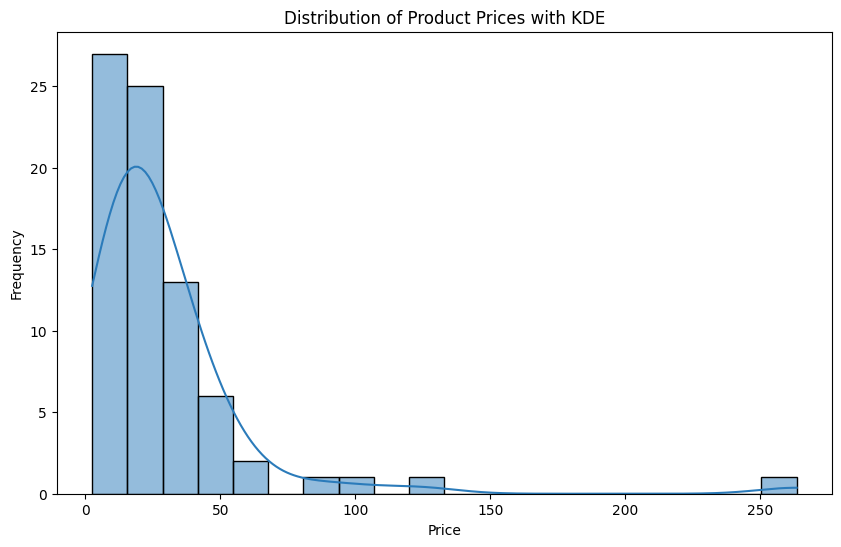

In [11]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['unit_price'], bins=20, kde=True, color=sns.color_palette('Blues')[4])
plt.title("Distribution of Product Prices with KDE")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

Ürün Kategorilerine Göre Satışların Görselleştirilmesi

In [12]:
sql = """SELECT p.category_id, c.category_name, 
	ROUND(SUM(od.quantity * od.unit_price)::numeric, 2) AS TotalSales
FROM order_details od
JOIN products p ON od.product_id = p.product_id
JOIN categories c ON p.category_id = c.category_id
GROUP BY p.category_id, c.category_name;"""
df = pd.read_sql(sql, conn)

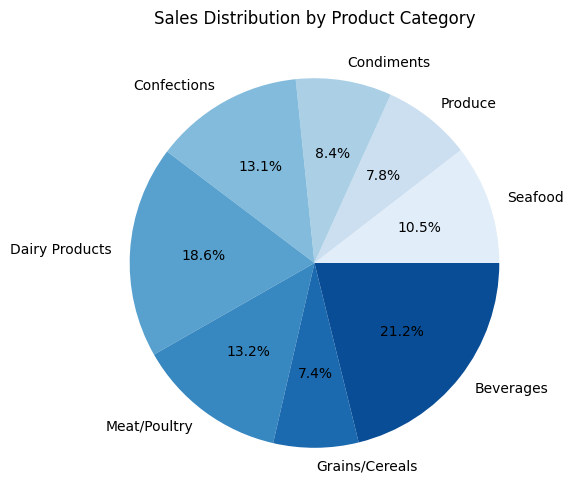

In [13]:
# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(df['totalsales'], labels=df['category_name'], autopct='%1.1f%%', colors=sns.color_palette('Blues', len(df)))
plt.title("Sales Distribution by Product Category")
plt.show()